Fold 1/5
Epoch [1/50], Train Loss: nan, Val Loss: nan
Epoch [2/50], Train Loss: nan, Val Loss: nan
Epoch [3/50], Train Loss: nan, Val Loss: nan
Epoch [4/50], Train Loss: nan, Val Loss: nan
Epoch [5/50], Train Loss: nan, Val Loss: nan
Epoch [6/50], Train Loss: nan, Val Loss: nan
Epoch [7/50], Train Loss: nan, Val Loss: nan
Epoch [8/50], Train Loss: nan, Val Loss: nan
Epoch [9/50], Train Loss: nan, Val Loss: nan
Epoch [10/50], Train Loss: nan, Val Loss: nan
Early stopping triggered


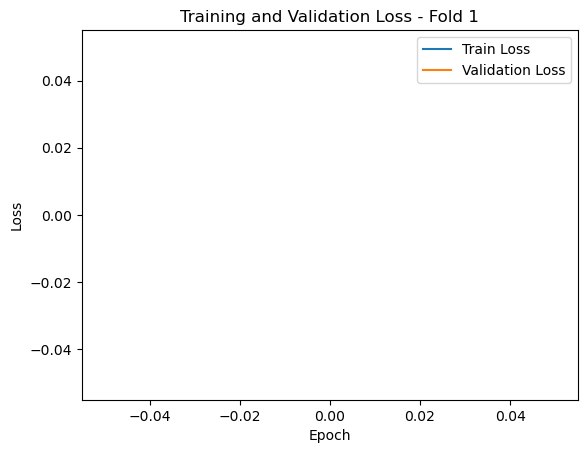

Fold 2/5
Epoch [1/50], Train Loss: nan, Val Loss: nan
Epoch [2/50], Train Loss: nan, Val Loss: nan
Epoch [3/50], Train Loss: nan, Val Loss: nan
Epoch [4/50], Train Loss: nan, Val Loss: nan
Epoch [5/50], Train Loss: nan, Val Loss: nan
Epoch [6/50], Train Loss: nan, Val Loss: nan
Epoch [7/50], Train Loss: nan, Val Loss: nan
Epoch [8/50], Train Loss: nan, Val Loss: nan
Epoch [9/50], Train Loss: nan, Val Loss: nan
Epoch [10/50], Train Loss: nan, Val Loss: nan
Early stopping triggered


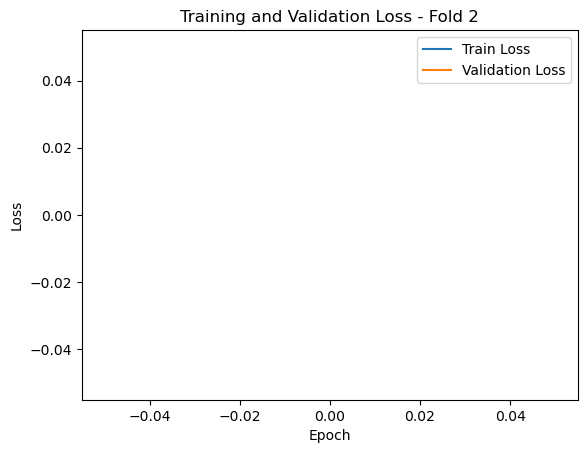

Fold 3/5
Epoch [1/50], Train Loss: nan, Val Loss: nan
Epoch [2/50], Train Loss: nan, Val Loss: nan
Epoch [3/50], Train Loss: nan, Val Loss: nan
Epoch [4/50], Train Loss: nan, Val Loss: nan
Epoch [5/50], Train Loss: nan, Val Loss: nan
Epoch [6/50], Train Loss: nan, Val Loss: nan
Epoch [7/50], Train Loss: nan, Val Loss: nan
Epoch [8/50], Train Loss: nan, Val Loss: nan
Epoch [9/50], Train Loss: nan, Val Loss: nan
Epoch [10/50], Train Loss: nan, Val Loss: nan
Early stopping triggered


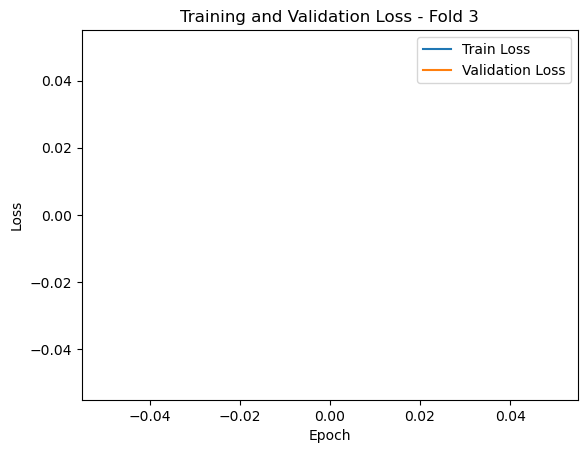

Fold 4/5
Epoch [1/50], Train Loss: nan, Val Loss: nan
Epoch [2/50], Train Loss: nan, Val Loss: nan
Epoch [3/50], Train Loss: nan, Val Loss: nan
Epoch [4/50], Train Loss: nan, Val Loss: nan
Epoch [5/50], Train Loss: nan, Val Loss: nan
Epoch [6/50], Train Loss: nan, Val Loss: nan
Epoch [7/50], Train Loss: nan, Val Loss: nan
Epoch [8/50], Train Loss: nan, Val Loss: nan
Epoch [9/50], Train Loss: nan, Val Loss: nan
Epoch [10/50], Train Loss: nan, Val Loss: nan
Early stopping triggered


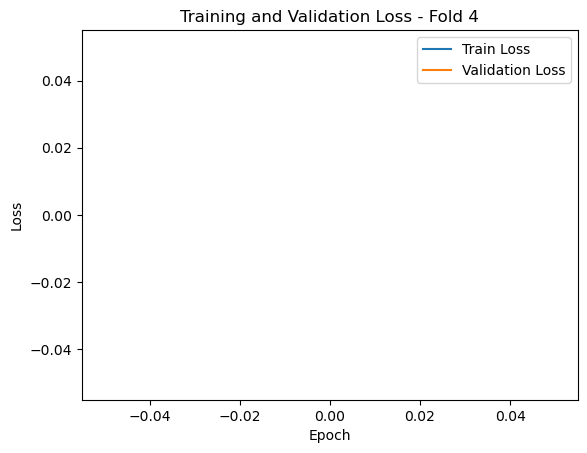

Fold 5/5
Epoch [1/50], Train Loss: nan, Val Loss: nan
Epoch [2/50], Train Loss: nan, Val Loss: nan
Epoch [3/50], Train Loss: nan, Val Loss: nan
Epoch [4/50], Train Loss: nan, Val Loss: nan
Epoch [5/50], Train Loss: nan, Val Loss: nan
Epoch [6/50], Train Loss: nan, Val Loss: nan
Epoch [7/50], Train Loss: nan, Val Loss: nan
Epoch [8/50], Train Loss: nan, Val Loss: nan
Epoch [9/50], Train Loss: nan, Val Loss: nan
Epoch [10/50], Train Loss: nan, Val Loss: nan
Early stopping triggered


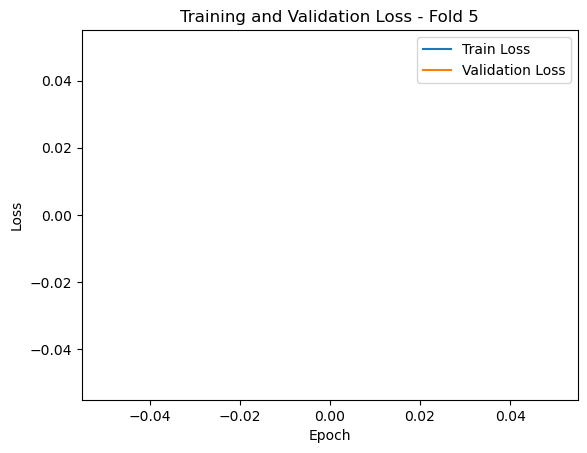


Average Cross-Validation Results:
accuracy                   0.54
0.0.precision              0.54
0.0.recall                 1.00
0.0.f1-score               0.70
0.0.support               32.80
1.0.precision              0.00
1.0.recall                 0.00
1.0.f1-score               0.00
1.0.support               27.80
macro avg.precision        0.27
macro avg.recall           0.50
macro avg.f1-score         0.35
macro avg.support         60.60
weighted avg.precision     0.29
weighted avg.recall        0.54
weighted avg.f1-score      0.38
weighted avg.support      60.60
dtype: float64


In [31]:
# Collect fold results and structure them for averaging
all_folds_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Reset best model state at the start of each fold
    best_model_state = None

    # Split data for this fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Create DataLoaders
    train_dataset = HeartDiseaseDataset(X_train, y_train)
    val_dataset = HeartDiseaseDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model, loss function, and optimizer
    model = LRInspiredNN(input_size=X.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping variables
    best_val_loss = np.inf
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.float()

            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_batch = y_batch.float()
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()  # Save best model state for current fold
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

    # Load the best model state for this fold, if available
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Evaluate model on validation set
    model.eval()
    with torch.no_grad():
        y_pred_prob = torch.sigmoid(model(torch.tensor(X_val, dtype=torch.float32)).squeeze()).numpy()
        y_pred = (y_pred_prob >= 0.5).astype(int)

    # Generate classification report for this fold and append to results
    report = classification_report(y_val, y_pred, output_dict=True)
    all_folds_results.append(report)

    # Plot training and validation loss for each fold
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss - Fold {fold + 1}")
    plt.legend()
    plt.show()

# Convert all_folds_results into a DataFrame
fold_results_df = pd.json_normalize(all_folds_results)

# Calculate the average metrics across all folds and display rounded results
average_report = fold_results_df.mean().round(2)
print("\nAverage Cross-Validation Results:")
print(average_report)
